# EDA (Medium)

dataset provenance: https://data.gov.ie/dataset/marine-institute-buoy-wave-forecast 

dataset info:
- full dataset contains wave data from 9 buoys
- full dataset contains data from 2002 - 2024 at 1 hour interval
- ton of missing values
- ***this notebook only uses the 2024 data (5 buoys)***

In [196]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from datetime import datetime
import folium

In [197]:
root_path = '..'

In [198]:
df = pd.read_csv(f'{root_path}/data/raw/waves-medium.csv')
df.head()

/var/folders/d0/7p4xxyy97qbb5_f74yjfh9vw0000gp/T/ipykernel_24414/1328230792.py:1: DtypeWarning: Columns (1,2,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{root_path}/data/raw/waves-medium.csv')


,station_id,longitude,latitude,time,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity,QC_Flag
0,NaN,degrees_east,degrees_north,UTC,millibars,degrees true,knots,knots,meters,seconds,degrees_true,meters,degrees_C,degrees_C,degrees_C,percent,NaN
1,M1,-11.2,53.1266,2001-02-06T13:00:00Z,967.6,270.0,21.98,33.1,NaN,NaN,NaN,NaN,8.9,NaN,9.0,NaN,1.0
2,M1,-11.2,53.1266,2001-02-06T14:00:00Z,969.8,270.0,23.93,35.0,NaN,NaN,NaN,NaN,8.5,NaN,9.0,NaN,1.0
3,M1,-11.2,53.1266,2001-02-06T15:00:00Z,972.0,270.0,19.07,31.1,NaN,NaN,NaN,NaN,8.9,NaN,9.0,NaN,1.0
4,M1,-11.2,53.1266,2001-02-06T16:00:00Z,973.6,270.0,15.95,25.3,NaN,NaN,NaN,NaN,9.1,NaN,9.0,NaN,1.0


In [199]:
df.drop(index=0,inplace=True)
df=df.reset_index(drop=True)
df = df[df['WaveHeight'].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 774478 entries, 480 to 881609
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   station_id           774478 non-null  object 
 1   longitude            774478 non-null  object 
 2   latitude             774478 non-null  object 
 3   time                 774478 non-null  object 
 4   AtmosphericPressure  766363 non-null  object 
 5   WindDirection        716083 non-null  object 
 6   WindSpeed            685926 non-null  object 
 7   Gust                 648993 non-null  object 
 8   WaveHeight           774478 non-null  object 
 9   WavePeriod           772714 non-null  object 
 10  MeanWaveDirection    346328 non-null  object 
 11  Hmax                 353364 non-null  object 
 12  AirTemperature       744497 non-null  object 
 13  DewPoint             371116 non-null  object 
 14  SeaTemperature       696529 non-null  object 
 15  RelativeHumidity    

let's drop some columns

In [200]:
print(df.station_id.unique())
print(len(df.station_id.unique()))

['M1' 'M2' 'M3' 'FS1' 'M4-Archive' 'M5' 'M6' 'M4' 'Belmullet-AMETS']
9


In [201]:
station_positions = df.groupby(['latitude', 'longitude',"station_id"]).size().reset_index().rename(columns={0: 'count'})
station_positions

,latitude,longitude,station_id,count
0,51.215956,-10.548261,M3,147435
1,51.4,-7.9,FS1,28404
2,51.690425,-6.704336,M5,143553
3,53.07482,-15.88135,M6,122423
4,53.1266,-11.2,M1,34816
5,53.4836,-5.4302,M2,140121
6,54.2659,-10.14221,Belmullet-AMETS,2731
7,54.6667,-9.0667,M4-Archive,30503
8,54.999967,-9.999136,M4,93862
9,51.215956,-10.548261,M3,1320


In [202]:
df.drop(columns=['MeanWaveDirection', 'Hmax', 'DewPoint', 'QC_Flag'], axis=1, inplace=True)
df = df.dropna()

df.head()

,station_id,longitude,latitude,time,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,AirTemperature,SeaTemperature,RelativeHumidity
1136,M1,-11.2,53.1266,2001-03-30T15:00:00Z,1005.8,210.0,7.0,70.0,1.7,7.0,10.0,9.2,90.0
1137,M1,-11.2,53.1266,2001-03-30T16:00:00Z,1005.4,200.0,7.98,11.7,1.6,7.0,10.0,9.2,92.2
1138,M1,-11.2,53.1266,2001-03-30T17:00:00Z,1004.4,190.0,9.92,13.6,1.8,7.0,9.9,9.3,93.5
1139,M1,-11.2,53.1266,2001-03-30T18:00:00Z,1003.4,180.0,11.09,15.6,1.6,6.0,9.7,9.3,94.1
1140,M1,-11.2,53.1266,2001-03-30T19:00:00Z,1002.4,180.0,14.01,19.5,1.6,6.0,9.3,9.3,95.4


In [203]:
df[['longitude', 'latitude', 'AtmosphericPressure', 'WindDirection', 'WindSpeed', 'Gust', 'WaveHeight', 'WavePeriod', 'AirTemperature', 'SeaTemperature', 'RelativeHumidity']] = df[['longitude', 'latitude','AtmosphericPressure', 'WindDirection', 'WindSpeed', 'Gust', 'WaveHeight', 'WavePeriod', 'AirTemperature', 'SeaTemperature', 'RelativeHumidity']].astype(float)

df['time'] = pd.to_datetime(df['time'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568081 entries, 1136 to 881609
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   station_id           568081 non-null  object             
 1   longitude            568081 non-null  float64            
 2   latitude             568081 non-null  float64            
 3   time                 568081 non-null  datetime64[ns, UTC]
 4   AtmosphericPressure  568081 non-null  float64            
 5   WindDirection        568081 non-null  float64            
 6   WindSpeed            568081 non-null  float64            
 7   Gust                 568081 non-null  float64            
 8   WaveHeight           568081 non-null  float64            
 9   WavePeriod           568081 non-null  float64            
 10  AirTemperature       568081 non-null  float64            
 11  SeaTemperature       568081 non-null  float64            
 12  Rela

In [204]:
mymap = folium.Map(location=[53.06050, -9.27100], zoom_start=6)

for index, row in station_positions.iterrows():
    folium.Marker(location=[row["latitude"], row["longitude"]], popup=row["station_id"]).add_to(mymap)

mymap

In [205]:
start_date = '2024-01-01'
end_date = '2024-12-31'
df_2024 = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

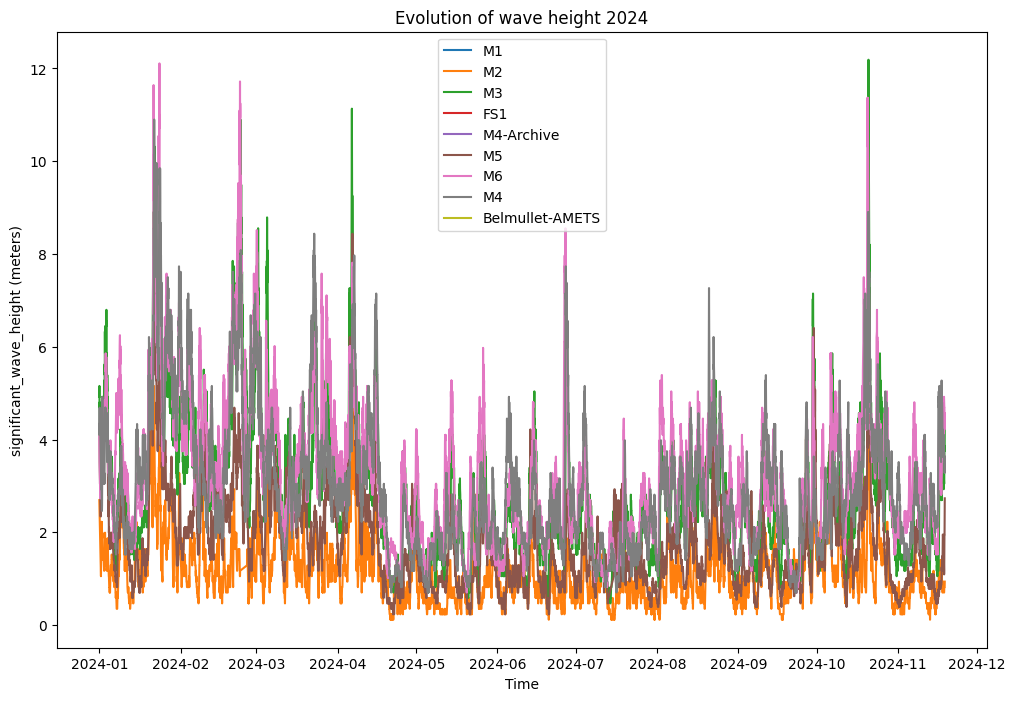

In [206]:
plt.figure(figsize=(12, 8))
color_cyc=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']
stations=['M1', 'M2', 'M3', 'FS1', 'M4-Archive', 'M5', 'M6', 'M4', 'Belmullet-AMETS']
for i,station in enumerate (stations):
    df1=df_2024[df_2024["station_id"]==station]
    plt.plot(df1['time'], df1['WaveHeight'],label=station,color=color_cyc[i])

plt.xlabel('Time')
plt.ylabel('significant_wave_height (meters)')
plt.title('Evolution of wave height 2024')
plt.legend()

plt.show()

In [207]:
station_groups = {station: group.drop("station_id", axis=1).sort_values('time') for station, group in df_2024.groupby('station_id')}

In [208]:
for station, group in station_groups.items():
    print(group.shape)

(7481, 12)
(7539, 12)
(7541, 12)
(7495, 12)
(7523, 12)


In [209]:
common_start = max([group['time'].min() for group in station_groups.values()])
common_end = min([group['time'].max() for group in station_groups.values()])
print(common_start, common_end)
full_time_range = pd.date_range(common_start, common_end, freq='h')

for station, group in station_groups.items():
    group.set_index('time', inplace=True)
    group = group.reindex(full_time_range)
    group['AtmosphericPressure'] = group['AtmosphericPressure'].interpolate()
    group['WindDirection'] = group['WindDirection'].interpolate()
    group['WindSpeed'] = group['WindSpeed'].interpolate()
    group['Gust'] = group['Gust'].interpolate()
    group['WaveHeight'] = group['WaveHeight'].interpolate()
    group['WavePeriod'] = group['WavePeriod'].interpolate()
    group['AirTemperature'] = group['AirTemperature'].interpolate()
    group['SeaTemperature'] = group['SeaTemperature'].interpolate()
    group['RelativeHumidity'] = group['RelativeHumidity'].interpolate()
    
    group.reset_index(inplace=True)
    group.rename(columns={'index': 'time'}, inplace=True)
    
    station_groups[station] = group



2024-01-01 00:00:00+00:00 2024-11-18 18:00:00+00:00


In [210]:
def datetime_to_float(d):
    return d.timestamp()

### Saving the Data as Torch Tensors

In [211]:
tensor_dict = {}
for station, df in station_groups.items():
    time_float = df['time'].apply(datetime_to_float).values
    
    target_tensor = torch.tensor(df['WaveHeight'].values, dtype=torch.float32)
    data_tensor = torch.tensor(df.drop(columns=['time', 'longitude', 'latitude'], axis=1).values, dtype=torch.float32)
    
    tensor_dict[station] = {
        "features": data_tensor,
        "target": target_tensor
    }

torch.save(tensor_dict, f'{root_path}/data/pt/waves-2024.pt')

test loading the data back in from pt file

In [212]:
loaded_data = torch.load(f'{root_path}/data/pt/waves-2024.pt')

for station, data in loaded_data.items():
    print(station)
    print(data['features'].shape)
    print(data['target'].shape)
    print()

M2
torch.Size([7747, 9])
torch.Size([7747])

M3
torch.Size([7747, 9])
torch.Size([7747])

M4
torch.Size([7747, 9])
torch.Size([7747])

M5
torch.Size([7747, 9])
torch.Size([7747])

M6
torch.Size([7747, 9])
torch.Size([7747])



/var/folders/d0/7p4xxyy97qbb5_f74yjfh9vw0000gp/T/ipykernel_24414/439797873.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(f'{root_path}/data/pt